In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
moving_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'+f).shape[2] == 100:
        moving_files.append(f)
        
sleeping_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'+f).shape[2] == 100:
        sleeping_files.append(f)

In [3]:
moving_files_train = [f for f in moving_files if (('0326' not in f) and ('0328' not in f))]
sleeping_files_train = [f for f in sleeping_files if (('0326' not in f) and ('0328' not in f))]

In [4]:
moving_files_val = [f for f in moving_files if (('0326' in f) or ('0328' in f))]
sleeping_files_val = [f for f in sleeping_files if (('0326' in f) or ('0328' in f))]

In [5]:
len(moving_files), len(sleeping_files)

(2809, 17148)

In [6]:
len(moving_files_train), len(sleeping_files_train)

(2765, 14325)

In [7]:
len(moving_files_val), len(sleeping_files_val)

(44, 2823)

In [8]:
import random
diff_train = len(sleeping_files_train)-len(moving_files_train)
for i in range(diff_train):
    ind = random.randint(0,len(moving_files_train)-1)
    x= moving_files_train[ind]
    moving_files_train.append(x)

In [9]:
len(moving_files_train), len(sleeping_files_train)

(14325, 14325)

In [10]:
moving_files = moving_files_train + moving_files_val
sleeping_files = sleeping_files_train + sleeping_files_val

len(moving_files), len(sleeping_files)

(14369, 17148)

In [11]:
m, s = 0, 0
for ind in range(len(moving_files)):
    x,y = moving_files[ind], sleeping_files[ind]
    if ('0326' not in x) and ('0328' not in x):
        m += 1
    if ('0326' not in y) and ('0328' not in y):
        s += 1

In [12]:
m,s

(14325, 14325)

In [13]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if (('0326' not in f) and ('0328' not in f))]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if (('0326' in f) or ('0328' in f))]
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0]
        spec = torch.from_numpy(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  spec.resize(spec.shape[0],100,10), label

In [14]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')

In [15]:
len(train_dataset), len(valid_dataset)

(28650, 2867)

In [16]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [17]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print(data.shape)
    print(data.reshape([data.shape[0],1,-1]).shape)
    print(labels.shape)
    break

/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([32, 62, 100, 10])
torch.Size([32, 1, 62000])
torch.Size([32, 1])


## Train and test functions

In [17]:
def train(loader):
    model.train()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        output, conv1, conv2 = model(data)
        loss = criterion(output.reshape(output.shape[0],-1), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
        predictions = []
        for o in output:
            if o.item() > .5:
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        preds.append(predictions.flatten())
        labs.append(labels.flatten().cpu().numpy())
        
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    accuracy = correct / total
    
    return epoch_loss, accuracy, preds, labs

In [18]:
def test(loader):
    model.eval()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            
            batch_losses.append(loss)
            
            #get accuracy
            predictions = []
            for o in output:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
            preds.append(predictions.flatten())
            labs.append(labels.flatten().cpu().numpy())
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        accuracy = correct/total
        
        return epoch_loss, accuracy, preds, labs

## Simple CNN

In [19]:
class CNN(nn.Module):
    def __init__(self, in_channels = 62, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=62, out_channels=124, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=124, out_channels=248, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(248*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [20]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.37013471126556396
Val loss for epoch 0: 0.39882203936576843
Train loss for epoch 1: 0.2297155261039734
Val loss for epoch 1: 0.12933073937892914
Train loss for epoch 2: 0.16598686575889587
Val loss for epoch 2: 0.1767689734697342
Train loss for epoch 3: 0.12054593116044998
Val loss for epoch 3: 0.5662453174591064
Train loss for epoch 4: 0.09952763468027115
Val loss for epoch 4: 0.2728874087333679
Train loss for epoch 5: 0.08501086384057999
Val loss for epoch 5: 0.6596342325210571
Train loss for epoch 6: 0.0581732913851738
Val loss for epoch 6: 0.28550758957862854
Train loss for epoch 7: 0.059266697615385056
Val loss for epoch 7: 0.2986094057559967
Train loss for epoch 8: 0.05766887590289116
Val loss for epoch 8: 0.29068782925605774
Train loss for epoch 9: 0.042975809425115585
Val loss for epoch 9: 0.8415354490280151
Train loss for epoch 10: 0.049401406198740005
Val loss for epoch 10: 0.20788536965847015
Train loss for epoch 11: 0.04185453802347183
Val loss for

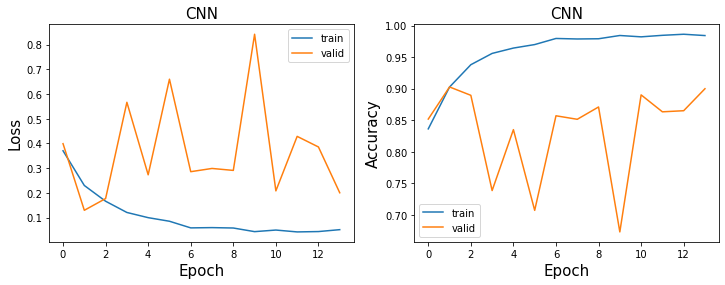

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("CNN", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("CNN", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [28]:
len(train_predictions)

15

In [30]:
tp, tl = train_predictions[:-1], train_labels[:-1]
vp, vl = validation_predictions[:-1], train_labels[:-1]

In [50]:
len(train_predictions[-1:])

1

In [80]:
validation_labels[-1:][0][-1:][0].shape

(19,)

In [68]:
predictions_train = np.stack(train_predictions[-1:][0][:-1]).flatten()
labels_train = np.stack(train_labels[-1:][0][:-1]).flatten()

predictions_val = np.stack(validation_predictions[-1:][0][:-1]).flatten()
labels_val = np.stack(validation_labels[-1:][0][:-1]).flatten()

In [83]:
labels_train.shape, predictions_train.shape, predictions_val.shape, labels_val.shape

((28640,), (28640,), (2848,), (2848,))

In [87]:
predictions_train = np.concatenate((predictions_train, train_predictions[-1:][0][-1:][0]))
labels_train = np.concatenate((labels_train, train_labels[-1:][0][-1:][0]))

predictions_val = np.concatenate((predictions_val, validation_predictions[-1:][0][-1:][0]))
labels_val = np.concatenate((labels_val, validation_labels[-1:][0][-1:][0]))

In [88]:
labels_train.shape, predictions_train.shape, predictions_val.shape, labels_val.shape

((28650,), (28650,), (2867,), (2867,))

In [89]:
df_train = pd.DataFrame({'predictions': predictions_train, 'labels': labels_train})
df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

In [90]:
df_train

,predictions,labels
0,0,0.0
1,0,0.0
2,1,1.0
3,0,0.0
4,0,0.0
...,...,...
28645,0,0.0
28646,0,0.0
28647,1,1.0
28648,0,0.0


In [91]:
df_train.groupby(['predictions','labels']).size().reset_index()

,predictions,labels,0
0,0,0.0,14199
1,0,1.0,285
2,1,0.0,126
3,1,1.0,14040


In [92]:
df_val.groupby(['predictions','labels']).size().reset_index()

,predictions,labels,0
0,0,0.0,38
1,0,1.0,461
2,1,0.0,6
3,1,1.0,2362


In [93]:
df_val[df_val['predictions']==0]

,predictions,labels
3,0,1.0
12,0,1.0
18,0,1.0
19,0,1.0
23,0,1.0
...,...,...
2862,0,0.0
2863,0,0.0
2864,0,0.0
2865,0,0.0


In [95]:
for batch_idx, (data, labels) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [32]:
conv1.shape

torch.Size([32, 124, 100, 10])

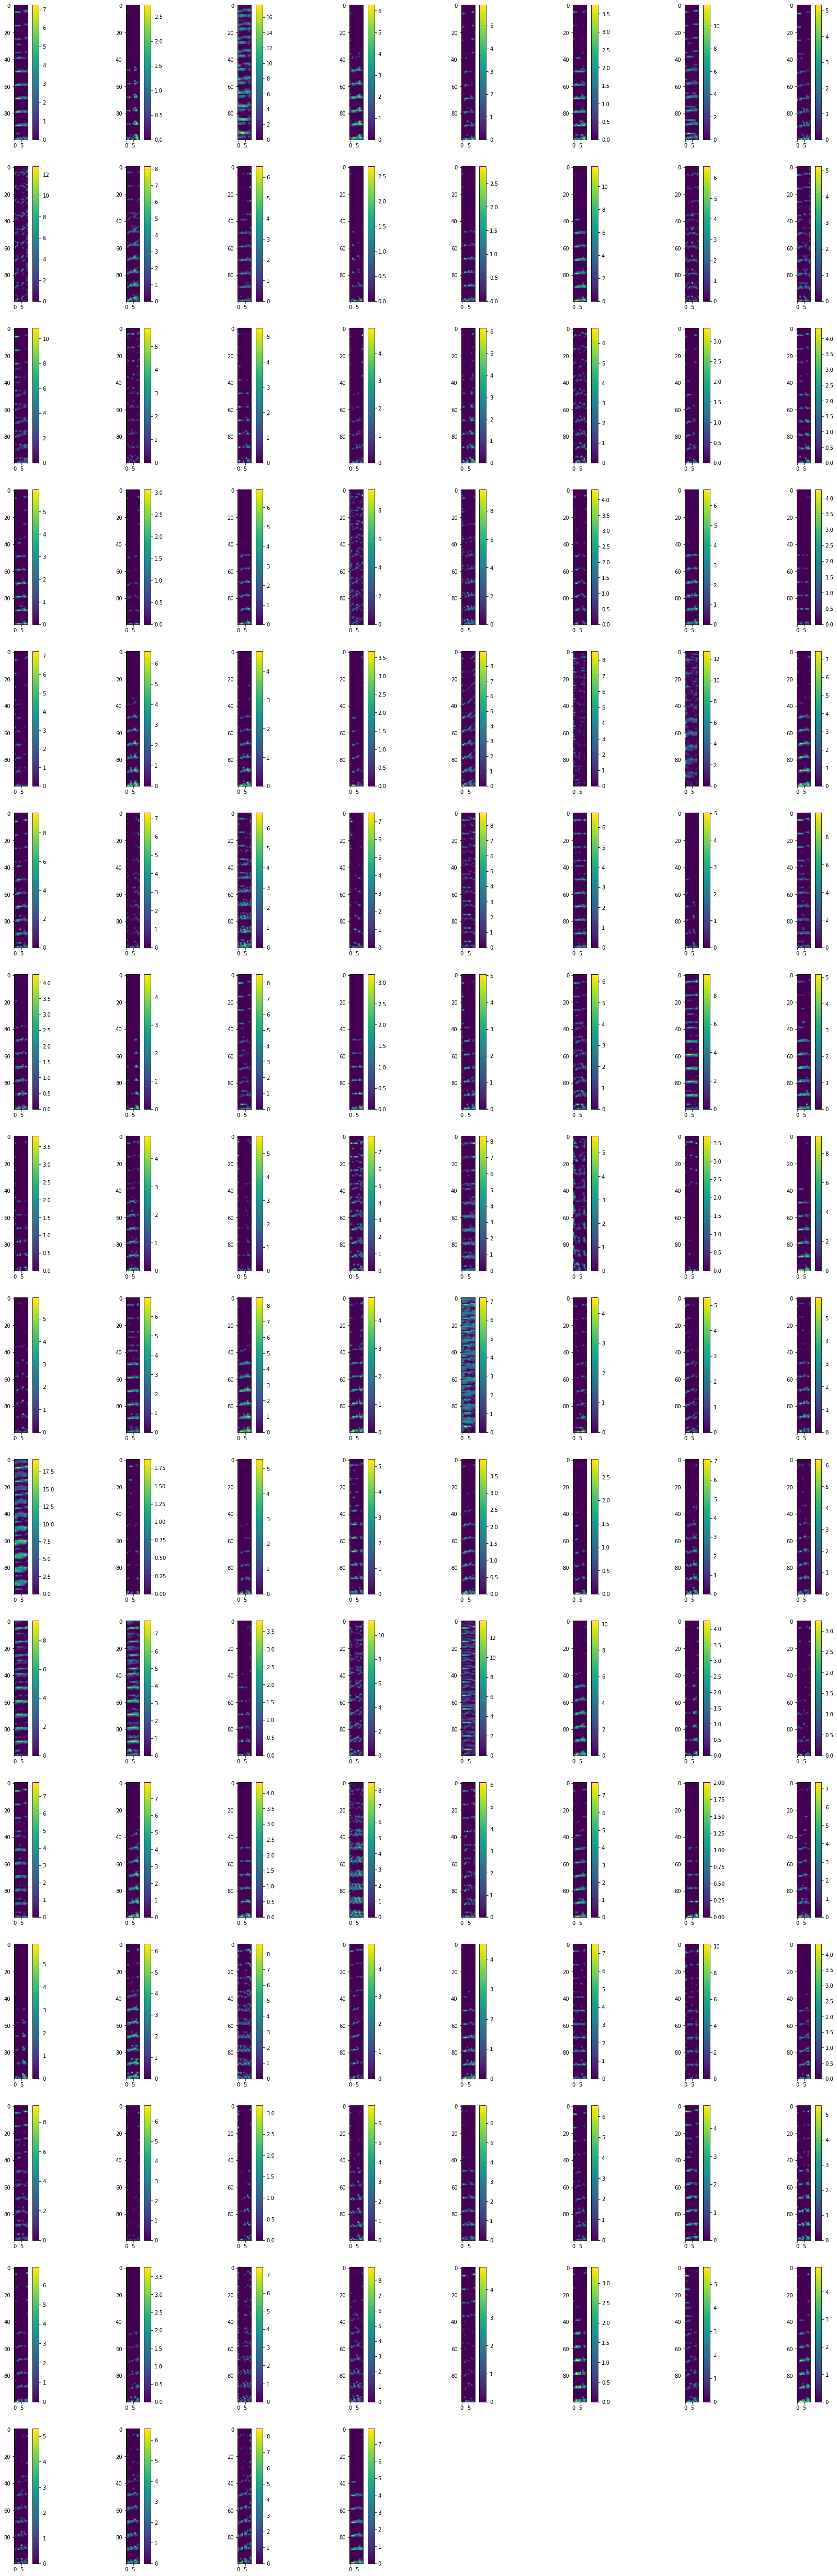

In [100]:
weights = conv1[0]
plt.figure(figsize=(30,90))
for i in range(124):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(16,8,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

In [33]:
conv2.shape

torch.Size([32, 248, 100, 10])

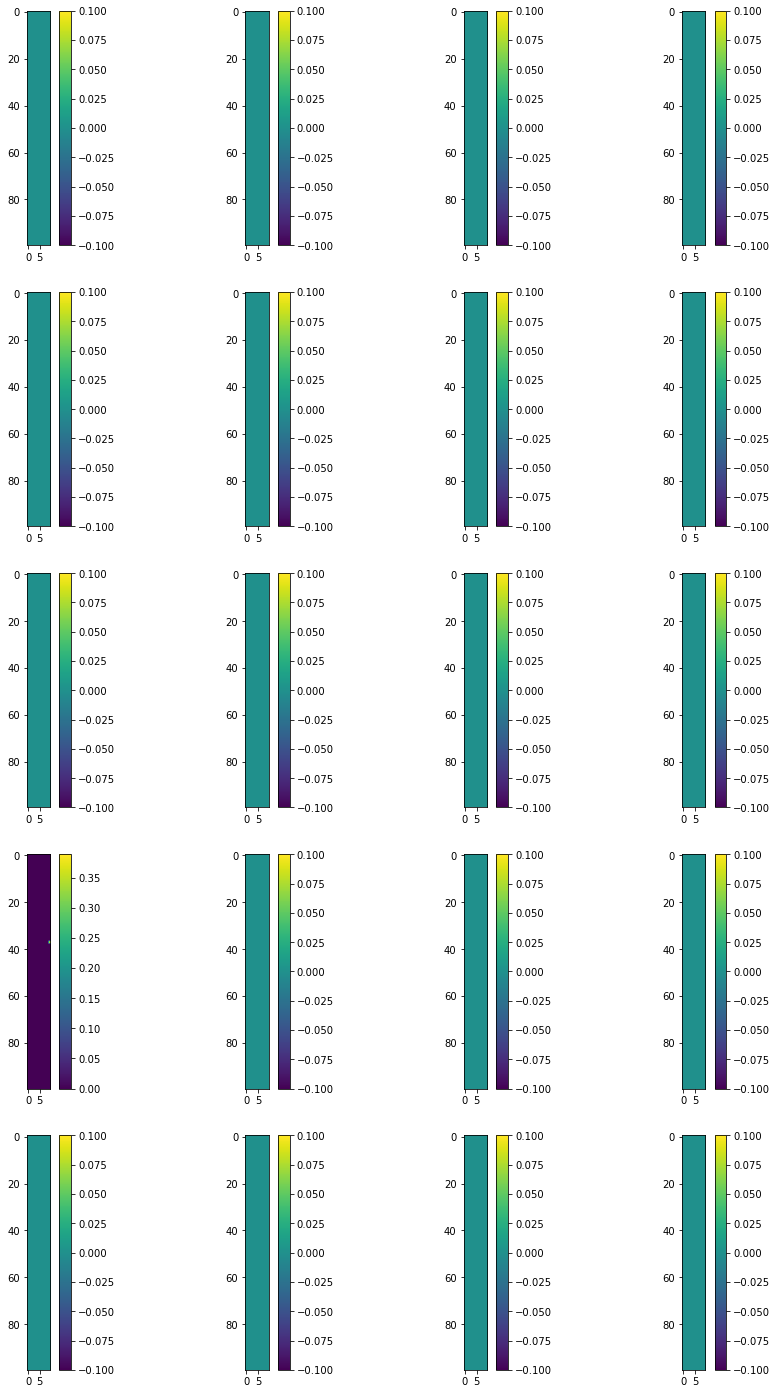

In [104]:
weights = conv2[0]
plt.figure(figsize=(15,25))
for i in range(20):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(5,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

## Split Data

In [2]:
moving_files_train = []
moving_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'):
    x = torch.from_numpy(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'+f))
    l = np.split(x,62)
    if (('0326' not in f) and ('0328' not in f)):
        for y in l:
            moving_files_train.append((y, torch.Tensor([0])))
    else:
        for y in l:
            moving_files_val.append((y, torch.Tensor([0])))
        
sleeping_files_train = []
sleeping_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'):
    x = torch.from_numpy(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'+f))
    l = np.split(x,62)
    if (('0326' not in f) and ('0328' not in f)):
        for y in l:
            sleeping_files_train.append((y, torch.Tensor([1])))
    else:
        for y in l:
            sleeping_files_val.append((y, torch.Tensor([1])))

In [3]:
len(moving_files_train), len(sleeping_files_train)

(171430, 888150)

In [4]:
# import random
# diff_train = len(sleeping_files_train)-len(moving_files_train)
# for i in range(diff_train):
#     ind = random.randint(0,len(moving_files_train)-1)
#     x= moving_files_train[ind]
#     moving_files_train.append(x)

sleeping_files_train = sleeping_files_train[:len(moving_files_train)]

In [5]:
len(moving_files_train), len(sleeping_files_train)

(171430, 171430)

In [6]:
len(moving_files_val), len(sleeping_files_val)

(2728, 175026)

In [7]:
moving_files = moving_files_train + moving_files_val
sleeping_files = sleeping_files_train + sleeping_files_val

In [8]:
len(moving_files), len(sleeping_files)

(174158, 346456)

In [9]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train',moving_files_train=moving_files_train,sleeping_files_train=sleeping_files_train,moving_files_val=moving_files_val,sleeping_files_val=sleeping_files_val):
        if mode == 'train':
            self.all_files = moving_files_train+sleeping_files_train
        elif mode == 'valid':
            self.all_files = moving_files_val+sleeping_files_val
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        return self.all_files[idx]

In [10]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')

In [11]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 64, shuffle = False)

In [12]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print(data.shape)
    print(data.reshape([data.shape[0],1,-1]).shape)
    print(labels.shape)
    break

torch.Size([64, 1, 10, 100])
torch.Size([64, 1, 1000])
torch.Size([64, 1])


In [13]:
class CNNsplit(nn.Module):
    def __init__(self, in_channels = 62, num_classes = 1):
        super(CNNsplit, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(16*10*100, num_classes)
#         self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x = relu(self.conv3(x2))
        x = relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [21]:
model = CNNsplit().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.3722614049911499
Val loss for epoch 0: 0.6248767375946045
Train loss for epoch 1: 0.28365570306777954
Val loss for epoch 1: 0.4818723797798157
Train loss for epoch 2: 0.23606066405773163
Val loss for epoch 2: 0.35767269134521484
Train loss for epoch 3: 0.20838379859924316
Val loss for epoch 3: 0.3978091776371002
Train loss for epoch 4: 0.19054608047008514
Val loss for epoch 4: 0.5222260355949402
Train loss for epoch 5: 0.17803125083446503
Val loss for epoch 5: 0.5215021371841431
Train loss for epoch 6: 0.1695198267698288
Val loss for epoch 6: 0.6133080124855042
Train loss for epoch 7: 0.16245527565479279
Val loss for epoch 7: 0.40410497784614563
Train loss for epoch 8: 0.1564977616071701
Val loss for epoch 8: 0.4465775191783905
Train loss for epoch 9: 0.15165281295776367
Val loss for epoch 9: 0.4287847876548767
Train loss for epoch 10: 0.14682669937610626
Val loss for epoch 10: 0.4594316780567169
Train loss for epoch 11: 0.1441263109445572
Val loss for epoch 1

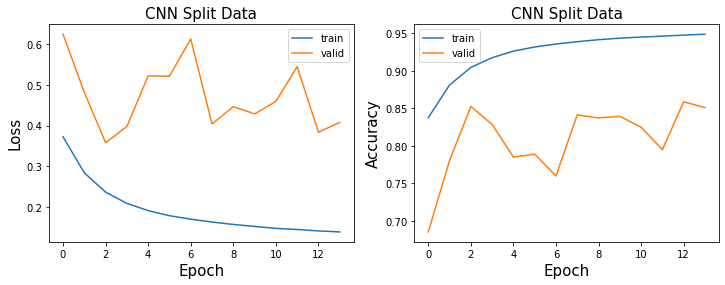

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("CNN Split Data", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("CNN Split Data", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [23]:
len(train_predictions)

15

In [24]:
validation_labels[-1:][0][-1:][0].shape

(26,)

In [25]:
predictions_train = np.stack(train_predictions[-1:][0][:-1]).flatten()
labels_train = np.stack(train_labels[-1:][0][:-1]).flatten()

predictions_val = np.stack(validation_predictions[-1:][0][:-1]).flatten()
labels_val = np.stack(validation_labels[-1:][0][:-1]).flatten()

In [26]:
predictions_train = np.concatenate((predictions_train, train_predictions[-1:][0][-1:][0]))
labels_train = np.concatenate((labels_train, train_labels[-1:][0][-1:][0]))

predictions_val = np.concatenate((predictions_val, validation_predictions[-1:][0][-1:][0]))
labels_val = np.concatenate((labels_val, validation_labels[-1:][0][-1:][0]))

In [27]:
labels_train.shape, predictions_train.shape, predictions_val.shape, labels_val.shape

((342860,), (342860,), (177754,), (177754,))

In [28]:
df_train = pd.DataFrame({'predictions': predictions_train, 'labels': labels_train})
df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

In [32]:
df_train.groupby(['labels', 'predictions']).size().reset_index()

,labels,predictions,0
0,0.0,0,161888
1,0.0,1,9542
2,1.0,0,7762
3,1.0,1,163668


In [31]:
df_val.groupby(['labels', 'predictions']).size().reset_index()

,labels,predictions,0
0,0.0,0,2416
1,0.0,1,312
2,1.0,0,28271
3,1.0,1,146755
